In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [35]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [49]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df.shape

(42000, 785)

In [52]:
train_set, val_set = train_test_split(df, test_size=0.2, random_state=42)
train_set.shape, val_set.shape

((33600, 785), (8400, 785))

In [53]:
X_train = tf.constant(train_set.iloc[:, 1:].values, shape=(len(train_set), 28, 28))
y_train = tf.one_hot(train_set["label"].values, 10)
X_val = tf.constant(val_set.iloc[:, 1:].values, shape=(len(val_set), 28, 28))
y_val = tf.one_hot(val_set["label"].values, 10)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

(TensorShape([33600, 28, 28]),
 TensorShape([33600, 10]),
 TensorShape([8400, 28, 28]),
 TensorShape([8400, 10]))

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(train_set))
train_dataset = train_dataset.batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)

In [55]:
MobileNetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, 
                                                             weights='imagenet')

In [56]:
MobileNetV2.trainable = False

In [57]:
inputs = tf.keras.Input(shape=(28, 28))
x = tf.expand_dims(inputs, axis=-1)
x = tf.keras.layers.Resizing(160, 160, interpolation="bilinear")(x)
x = tf.keras.layers.Lambda(lambda  t: tf.tile(t, [1, 1, 1, 3]))(x)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)
x = MobileNetV2(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [58]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.expand_dims_4 (TFOpLambd  (None, 28, 28, 1)        0         
 a)                                                              
                                                                 
 resizing_4 (Resizing)       (None, 160, 160, 1)       0         
                                                                 
 lambda_4 (Lambda)           (None, 160, 160, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                    

In [59]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="CategoricalCrossentropy",
              metrics=["accuracy"])

In [60]:
history = model.fit(train_dataset,
                    epochs=5,
                    steps_per_epoch=len(train_dataset),
                    validation_data=val_dataset,
                    validation_steps=int(len(val_dataset)))

Epoch 1/5
1050/1050 [==============================] - 33s 29ms/step - loss: 0.2806 - accuracy: 0.9196 - val_loss: 0.1453 - val_accuracy: 0.9557
Epoch 2/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.1239 - accuracy: 0.9618 - val_loss: 0.1158 - val_accuracy: 0.9637
Epoch 3/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0954 - accuracy: 0.9715 - val_loss: 0.0996 - val_accuracy: 0.9683
Epoch 4/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0794 - accuracy: 0.9759 - val_loss: 0.0973 - val_accuracy: 0.9696
Epoch 5/5
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0683 - accuracy: 0.9799 - val_loss: 0.0922 - val_accuracy: 0.9702


In [61]:
model.evaluate(val_dataset)

263/263 [==============================] - 6s 22ms/step - loss: 0.0922 - accuracy: 0.9702


[0.09221786260604858, 0.9702380895614624]

In [66]:
test_set = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
test_set = tf.constant(test_set.values, shape=(len(test_set), 28, 28))

In [68]:
p = model.predict(test_set)

875/875 [==============================] - 18s 19ms/step


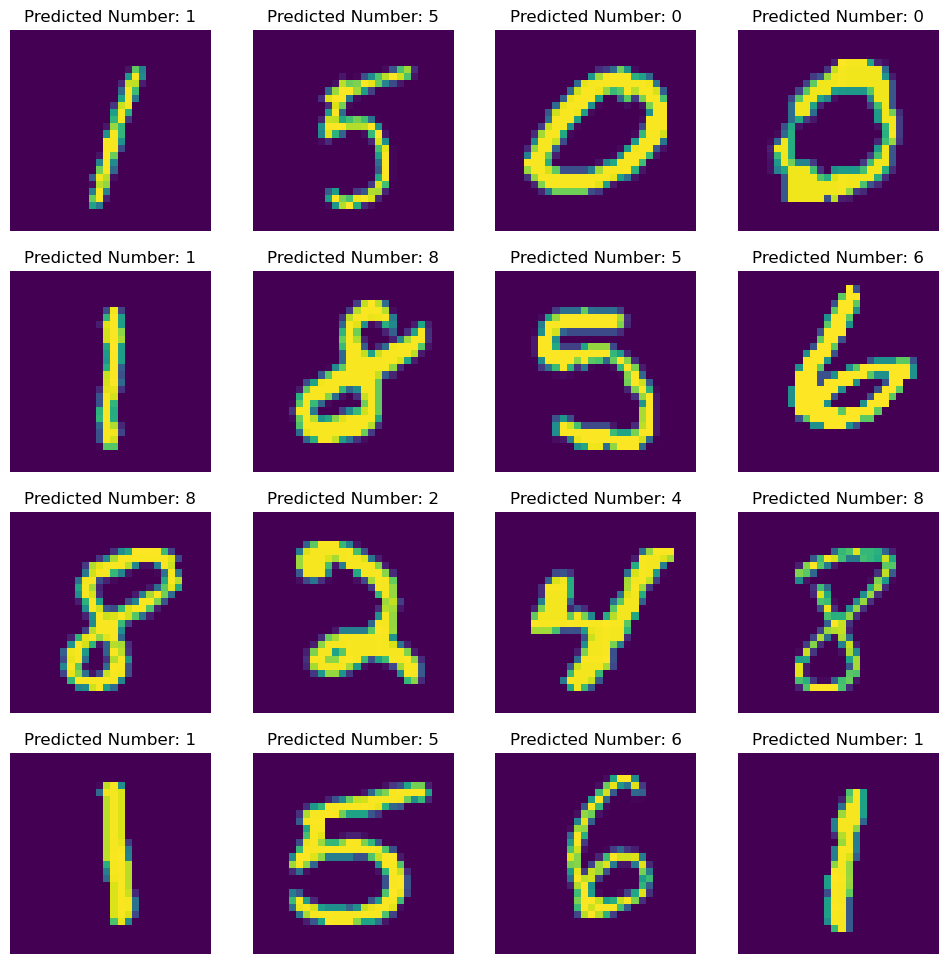

In [82]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 17):
    idx = random.randint(0, len(test_set))
    plt.subplot(4, 4, i)
    plt.imshow(test_set[idx])
    plt.axis(False)
    plt.title(f"Predicted Number: {p[idx].argmax()}")